---
# Portfolio_Optimizacion.ipynb  
**Autor:** Lucas Mauricio Velázquez  
**Tesis de Maestría en Ciencia de Datos**, Instituto Tecnológico de Buenos Aires (ITBA), Julio 2025  
**Directora de Tesis:** Dra. Leticia I. Gómez  

_Este notebook forma parte del trabajo de tesis “Optimización de Carteras con Deep Learning”._
---


**Celda 1. Instalación de Dependencias**  
En esta celda se instalan las librerías necesarias para el proyecto: *yfinance*, *keras-tuner* y *cvxpy*.

In [1]:
!pip install yfinance keras-tuner cvxpy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


**Celda 2. Importación de Librerías**  
Se importan las librerías esenciales para manipulación de datos, construcción de modelos de deep learning, optimización y visualización.

In [2]:
"""# 2. Importación de Librerías

Se importan las librerías esenciales para manipulación de datos, construcción de modelos de deep learning, optimización y visualización.
"""

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler  # Se usará solo para precios en MSAD
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import keras_tuner as kt
from scipy.optimize import minimize
import cvxpy as cp
from google.colab import drive
import os

plt.style.use('ggplot')
print("Librerías importadas correctamente.")


Librerías importadas correctamente.


**Celda 3. Carga y Preparación de Datos**  
Se carga un archivo Excel con datos históricos de cada ticker, se filtran y se alinean (interpolando en caso de datos faltantes) para combinarlos en un único DataFrame.

In [4]:
# Definir tickers y parámetros generales
tickers = ['VTI', 'AGG', 'DBC', '^VIX']
start_date = '2007-01-01'
end_date = '2023-12-01'
window_size = 50
max_trials = 10
executions_per_trial = 2
epochs = 50
batch_size   = 32
# Definir el período de test
test_start_str = '2020-01-01'
test_end_str   = '2020-12-31'
test_start = pd.to_datetime(test_start_str)
test_end   = pd.to_datetime(test_end_str)
print(f"Test Start = {test_start.date()}, Test End = {test_end.date()}")

# Cargar datos desde Excel y filtrarlos
data = {}
for ticker in tickers:
    df = pd.read_excel('datos.xlsx', sheet_name=ticker)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    df.set_index('Date', inplace=True)
    df = df[['Adj Close', 'Log Return']].dropna()
    data[ticker] = df

print("Datos cargados y preparados desde Excel.")

# Alinear y combinar datos
all_dates = sorted(set.union(*[set(df.index) for df in data.values() if not df.empty]))
common_index = pd.DatetimeIndex(all_dates)

aligned_data = {}
for ticker, df_ in data.items():
    if not df_.empty:
        reindexed_df = df_.reindex(common_index)
        reindexed_df = reindexed_df.interpolate(method='linear').bfill().ffill()
        aligned_data[ticker] = reindexed_df

combined_data = pd.concat(aligned_data, axis=1)
combined_data.columns = [f"{ticker}_{col}" for ticker in aligned_data.keys() for col in ['Adj Close', 'Log Return']]
print("Datos combinados preparados.")
print("Tamaño de combined_data:", combined_data.shape)


Test Start = 2020-01-01, Test End = 2020-12-31
Datos cargados y preparados desde Excel.
Datos combinados preparados.
Tamaño de combined_data: (4258, 8)


**Celda 4. Definición de Funciones Auxiliares**  
Se definen funciones para:
- Crear ventanas (sliding windows) para entrenar y predecir.
- Calcular la pérdida basada en el Sharpe Ratio (con precauciones para evitar NaN).
- Calcular el máximo drawdown, métricas de rendimiento y el retorno anualizado.

In [5]:
"""**Celda 4. Definición de Funciones Auxiliares**
Se definen funciones para:
- Crear ventanas (sliding windows) para entrenar y predecir.
- Calcular la pérdida basada en el Sharpe Ratio (con precauciones para evitar NaN).
- Calcular el máximo drawdown, métricas de rendimiento y el retorno anualizado.
"""

def create_windows(data, window_size=window_size):
    n_assets = len(tickers)
    log_return_indices = [2*i + 1 for i in range(n_assets)]
    X, y = [], []
    for i in range(len(data) - window_size):
        window = data.iloc[i:i+window_size].values
        target = data.iloc[i+window_size, log_return_indices].values
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

def sharpe_loss(y_true, y_pred):
    portfolio_return = tf.reduce_sum(y_pred * y_true, axis=1)
    mean_return = tf.reduce_mean(portfolio_return)
    risk = tf.math.reduce_std(portfolio_return)
    epsilon = 1e-6
    risk_safe = tf.maximum(risk, epsilon)
    sharpe_ratio = mean_return / risk_safe
    loss = -sharpe_ratio
    loss = tf.where(tf.math.is_nan(loss), tf.zeros_like(loss), loss)
    return loss

def calc_mdd(returns):
    cumprod_array = np.cumprod(1 + returns)
    running_max = np.maximum.accumulate(cumprod_array)
    drawdown = (cumprod_array - running_max) / running_max
    return drawdown.min()

def calc_metrics(returns):
    mean_ = returns.mean()
    std_ = returns.std()
    sharpe_ = mean_ / (std_ + 1e-9)
    negative_returns = returns[returns < 0]
    downside_std = negative_returns.std() if len(negative_returns) > 0 else 1e-9
    sortino_ = mean_ / (downside_std + 1e-9)
    mdd_ = calc_mdd(returns)
    return mean_, std_, sharpe_, sortino_, mdd_

def calc_annualized_return(returns, dates):
    total_ret = (1 + returns).prod() - 1
    num_days = (dates[-1] - dates[0]).days
    if num_days <= 0:
        return 0.0
    ann_ret = (1 + total_ret)**(365/num_days) - 1
    return ann_ret

print("Funciones auxiliares definidas.")


Funciones auxiliares definidas.


**Celda 5. Definición de Funciones Constructoras con Tuner**  
Se definen las funciones para construir modelos deep learning utilizando Keras Tuner:
- **LSTM End-to-End**
- **DMLP End-to-End**
- **LSTM+MSAD** y **DMLP+MSAD**

In [ ]:
def build_model_lstm_end_to_end_tuner_hp(hp):
    units = hp.Int('units', min_value=32, max_value=256, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    dense_units = hp.Int('dense_units', min_value=16, max_value=128, step=16)
    lr = hp.Choice('lr', [0.001, 0.0005, 0.0001])
    input_layer = Input(shape=(window_size, combined_data.shape[1]))
    lstm_layer = LSTM(units, return_sequences=False)(input_layer)
    dropout_layer = Dropout(dropout_rate)(lstm_layer)
    dense_layer = Dense(dense_units, activation='relu')(dropout_layer)
    output_layer = Dense(len(tickers), activation='softmax')(dense_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(lr), loss=sharpe_loss)
    return model

def build_model_dmlp_end_to_end_tuner_hp(hp):
    dense1 = hp.Int('dense1', min_value=32, max_value=256, step=32)
    dense2 = hp.Int('dense2', min_value=16, max_value=128, step=16)
    lr = hp.Choice('lr', [0.001, 0.0005, 0.0001])
    model = tf.keras.Sequential([
        Flatten(input_shape=(window_size, combined_data.shape[1])),
        Dense(dense1, activation='relu'),
        Dense(dense2, activation='relu'),
        Dense(len(tickers), activation='softmax')
    ])
    model.compile(optimizer=Adam(lr), loss=sharpe_loss)
    return model

def build_model_lstm_msad_tuner_hp(hp):
    units1 = hp.Int('units1', min_value=32, max_value=128, step=32)
    units2 = hp.Int('units2', min_value=16, max_value=64, step=16)
    lr = hp.Choice('lr', [0.001, 0.0005, 0.0001])
    model = tf.keras.Sequential([
         LSTM(units1, return_sequences=True, input_shape=(window_size, combined_data.shape[1])),
         LSTM(units2, return_sequences=False),
         Dense(len(tickers), activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mae')
    return model

def build_model_dmlp_msad_tuner_hp(hp):
    dense_units1 = hp.Int('dense_units1', min_value=32, max_value=128, step=32)
    dense_units2 = hp.Int('dense_units2', min_value=16, max_value=64, step=16)
    lr = hp.Choice('lr', [0.001, 0.0005, 0.0001])
    model = tf.keras.Sequential([
         Flatten(input_shape=(window_size, combined_data.shape[1])),
         Dense(dense_units1, activation='relu'),
         Dense(dense_units2, activation='relu'),
         Dense(len(tickers), activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mae')
    return model

print("Funciones constructoras con tuner definidas.")


Funciones constructoras con tuner definidas.


**Celda 6. Función `find_test_start` con Debug**  
Esta función retrocede desde la fecha efectiva de inicio del test para asegurarse de contar con una ventana completa (de tamaño `window_size`) para la primera predicción.

In [ ]:
"""# 6. Función `find_test_start` con Debug

Esta función retrocede desde la fecha efectiva de inicio del test para asegurarse de contar con una ventana completa (de tamaño `window_size`) para la primera predicción.
"""

def find_test_start(effective_start_date, window_size, combined_data):
    test_start_candidate = effective_start_date - pd.Timedelta(days=window_size)
    tries = 0
    max_tries = 100

    while tries < max_tries:
        data_between = combined_data.loc[
            (combined_data.index >= test_start_candidate) &
            (combined_data.index < effective_start_date)
        ]
        current_shape = data_between.shape[0]
        print(f"[DEBUG] Intento {tries}: test_start_candidate={test_start_candidate.date()}, registros={current_shape}")
        if current_shape >= window_size:
            print(f"[DEBUG] Se encontró un rango con {current_shape} registros >= {window_size}. Usando test_start={test_start_candidate.date()}")
            return test_start_candidate
        else:
            test_start_candidate -= pd.Timedelta(days=1)
            tries += 1
            if test_start_candidate < combined_data.index[0]:
                break

    raise ValueError(
        f"No es posible encontrar un período de prueba con {window_size} días "
        f"antes de {effective_start_date.date()}."
    )

# Ejecutar y reasignar test_start
new_test_start = find_test_start(test_start, window_size, combined_data)
print(f"[INFO] Se usará test_start={new_test_start.date()}")
test_start = new_test_start



[DEBUG] Intento 0: test_start_candidate=2019-11-12, registros=34
[DEBUG] Intento 1: test_start_candidate=2019-11-11, registros=35
[DEBUG] Intento 2: test_start_candidate=2019-11-10, registros=35
[DEBUG] Intento 3: test_start_candidate=2019-11-09, registros=35
[DEBUG] Intento 4: test_start_candidate=2019-11-08, registros=36
[DEBUG] Intento 5: test_start_candidate=2019-11-07, registros=37
[DEBUG] Intento 6: test_start_candidate=2019-11-06, registros=38
[DEBUG] Intento 7: test_start_candidate=2019-11-05, registros=39
[DEBUG] Intento 8: test_start_candidate=2019-11-04, registros=40
[DEBUG] Intento 9: test_start_candidate=2019-11-03, registros=40
[DEBUG] Intento 10: test_start_candidate=2019-11-02, registros=40
[DEBUG] Intento 11: test_start_candidate=2019-11-01, registros=41
[DEBUG] Intento 12: test_start_candidate=2019-10-31, registros=42
[DEBUG] Intento 13: test_start_candidate=2019-10-30, registros=43
[DEBUG] Intento 14: test_start_candidate=2019-10-29, registros=44
[DEBUG] Intento 15: 

**Celda 7. Pipeline Genérico End-to-End con Tuner (Raw Data)**  
Se define el pipeline para entrenar un modelo LSTM End-to-End usando datos crudos (sin escalado). El modelo predice asignaciones de capital (pesos) y se guarda con un sufijo `_raw_`. Además, se entrena también el modelo DMLP End-to-End sin guardado y aplicando `desired_return`.

In [ ]:
import os
import json
import numpy as np
import cvxpy as cp
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

def lstm_end_to_end_pipeline(data, train_period, val_period, test_period,
                             strategy, window_size, epochs, batch_size,
                             model_save_path, use_tuner=False):

    if os.path.exists(model_save_path):
        model = tf.keras.models.load_model(
            model_save_path,
            custom_objects={'sharpe_loss': sharpe_loss}
        )
        print(f"Modelo cargado desde {model_save_path}")
        return model, None

    train_data = data.loc[train_period]
    val_data   = data.loc[val_period] if val_period is not None else pd.DataFrame()
    full_train = pd.concat([train_data, val_data])
    full_df    = full_train.copy()

    X_train, y_train = create_windows(full_df.loc[train_data.index], window_size)
    if not val_data.empty:
        X_val, y_val = create_windows(full_df.loc[val_data.index], window_size)
    else:
        X_val, y_val = (None, None)

    if use_tuner:
        tuner = kt.RandomSearch(
            build_model_lstm_end_to_end_tuner_hp,
            objective='val_loss',
            max_trials=max_trials,
            executions_per_trial=1,
            directory='tuner_dir_lstm_ete',
            project_name='lstm_ete_tuning'
        )
        tuner.search(X_train, y_train,
                     validation_split=0.1,
                     epochs=20,
                     batch_size=batch_size,
                     verbose=1)
        best_hp = tuner.get_best_hyperparameters(1)[0]
        with open(model_save_path.replace('.h5', '.json'), 'w') as f:
            json.dump(best_hp.values, f)
        model = tuner.hypermodel.build(best_hp)
        model.fit(X_train, y_train,
                  validation_split=0.1,
                  epochs=epochs,
                  batch_size=batch_size,
                  verbose=1)
    else:
        model = build_model_lstm_end_to_end_tuner_hp()
        if strategy == '1entrenamiento_10%':
            model.fit(X_train, y_train,
                      validation_split=0.1,
                      epochs=epochs,
                      batch_size=batch_size,
                      verbose=1)
        else:
            if X_val is not None and y_val is not None:
                model.fit(X_train, y_train,
                          validation_data=(X_val, y_val),
                          epochs=epochs,
                          batch_size=batch_size,
                          verbose=1)
            else:
                model.fit(X_train, y_train,
                          validation_split=0.1,
                          epochs=epochs,
                          batch_size=batch_size,
                          verbose=1)

    model.save(model_save_path)
    print(f"Modelo entrenado y guardado en {model_save_path}")
    return model, None

def dmlp_end_to_end_pipeline(data, train_period, val_period, test_period,
                             window_size, epochs, batch_size,
                             use_tuner=False, desired_return=0.002):
    # **Nueva función**: nunca guarda en disco
    train_data = data.loc[train_period]
    X_train, y_train = create_windows(train_data, window_size)

    if use_tuner:
        tuner = kt.RandomSearch(
            build_model_dmlp_end_to_end_tuner_hp,
            objective='val_loss',
            max_trials=max_trials,
            executions_per_trial=1,
            directory='tuner_dir_dmlp_ete',
            project_name='dmlp_ete_tuning'
        )
        tuner.search(X_train, y_train,
                     validation_split=0.1,
                     epochs=20,
                     batch_size=batch_size,
                     verbose=1)
        best_hp = tuner.get_best_hyperparameters(1)[0]

        # ─── Inserción para guardar hiperparámetros ───
        print("Mejores hiperparámetros DMLP End-to-End:")
        for key, val in best_hp.values.items():
            print(f"  - {key}: {val}")
        with open("dmlp_ete_best_hyperparams.json", "w") as f:
            json.dump(best_hp.values, f)
        # ───────────────────────────────────────────────

        model = tuner.hypermodel.build(best_hp)
    else:
        model = build_model_dmlp_end_to_end_tuner_hp()

    model.compile(optimizer=Adam(), loss=sharpe_loss)
    model.fit(X_train, y_train,
              validation_split=0.1,
              epochs=epochs,
              batch_size=batch_size,
              verbose=1)

    # Construcción de ventanas de test
    test_data  = data.loc[test_period]
    X_pred     = [ test_data.iloc[i:i+window_size].values for i in range(len(test_data)-window_size) ]
    pred_dates = [ test_data.index[i+window_size]                 for i in range(len(test_data)-window_size) ]
    X_pred     = np.array(X_pred)

    weights_pred = model.predict(X_pred)
    adjusted = []
    for w, date in zip(weights_pred, pred_dates):
        r = combined_data.loc[date, [f"{t}_Log Return" for t in tickers]].values
        if np.dot(w, r) < desired_return:
            x = cp.Variable(len(w))
            obj = cp.Minimize(cp.sum_squares(x - w))
            cons = [cp.sum(x)==1, x>=0, r @ x>=desired_return]
            cp.Problem(obj, cons).solve(solver=cp.SCS)
            adjusted.append(x.value if x.value is not None else w)
        else:
            adjusted.append(w)
    return np.array(adjusted), pred_dates

# Slices y rutas (idénticos al original)
train_period           = slice('2007-01-01', test_start.strftime('%Y-%m-%d'))
val_period             = None
test_period            = slice(test_start, test_end)

test_start_str         = test_start.strftime('%Y-%m-%d')
test_end_str           = test_end.strftime('%Y-%m-%d')
model_save_path_single = f"/content/drive/MyDrive/models/lstm_ete_raw_{test_start_str}_{test_end_str}_{window_size}_mt{max_trials}.h5"
strategy               = '1entrenamiento_10%'

# LSTM End-to-End: carga/entrena y guarda
model_single, _ = lstm_end_to_end_pipeline(
    combined_data,
    train_period,
    val_period,
    test_period,
    strategy,
    window_size,
    epochs=epochs,
    batch_size=batch_size,
    model_save_path=model_save_path_single,
    use_tuner=True
)
print("\nPipeline LSTM End-to-End (1 entrenamiento, 10% validación) completado.")

# DMLP End-to-End: siempre reentrena, no guarda
weights_pred_dmlp_raw, pred_dates_dmlp_raw = dmlp_end_to_end_pipeline(
    combined_data,
    train_period,
    val_period,
    test_period,
    window_size,
    epochs=epochs,
    batch_size=batch_size,
    use_tuner=True,
    desired_return=0.002
)
print("Pipeline DMLP End-to-End (1 entrenamiento, raw) completado.")


Trial 10 Complete [00h 00m 13s]
val_loss: -0.17446808516979218

Best val_loss So Far: -0.17446808516979218
Total elapsed time: 00h 02m 03s
Mejores hiperparámetros DMLP End-to-End:
  - dense1: 160
  - dense2: 80
  - lr: 0.001
Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0115 - val_loss: 7.6273e-04
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0062 - val_loss: 7.6273e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0190 - val_loss: 7.6273e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0214 - val_loss: 7.6273e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - val_loss: 7.6273e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0165 - val_loss: 7.6273e-04
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - val_loss: 7.6273e-04
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - val_loss: 7.6273e-04
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -6.9467e-

**Celda 8. Estrategias Adicionales (Reentrenamiento Periódico y 4y+1y)**  
Se implementan dos estrategias adicionales para LSTM End-to-End y DMLP End-to-End.

In [ ]:
# 8. Estrategias Adicionales (Reentrenamiento Periódico y 4y+1y)

from datetime import datetime

version_tag = 'v2' # <— define aquí tu “prefijo” de versión

# Generación de fechas de corte cada 2 años hasta el inicio del test
start_datetime = pd.to_datetime(start_date)
two_years       = pd.DateOffset(years=2)

cutoff_dates = []
current_date = start_datetime + two_years
while current_date <= test_start:
    cutoff_dates.append(current_date)
    current_date += two_years

print("Fechas de cutoff para reentrenamiento:", cutoff_dates)

# Diccionario para almacenar modelos reentrenados
lstm_ete_models = {}

for cutoff in cutoff_dates:
    print(f"\nEntrenando/cargando modelo hasta {cutoff.date()}...")
    # Ruta de guardado para el LSTM retrain
    model_save_path_retrain = (
        f"/content/drive/MyDrive/models/"
        f"{version_tag}_lstm_ete_model_raw_{cutoff.strftime('%Y-%m-%d')}_"
        f"{test_start_str}_{test_end_str}_{window_size}_mt{max_trials}_RETRAIN.h5"
    )
    # Periodo de entrenamiento: desde start_date hasta justo **el cutoff actual**
    train_period_final = slice(start_date, cutoff.strftime('%Y-%m-%d'))

    # 1) LSTM End-to-End reentrenamiento (con carga/guardado automático)
    model_lstm, _ = lstm_end_to_end_pipeline(
        combined_data,
        train_period_final,
        None,
        None,
        'reentrenamiento',
        window_size,
        epochs=epochs,
        batch_size=batch_size,
        model_save_path=model_save_path_retrain,
        use_tuner=True
    )

    # 2) DMLP End-to-End reentrenamiento (sin guardado en disco)
    weights_dmlp_retrain, dates_dmlp_retrain = dmlp_end_to_end_pipeline(
        combined_data,
        train_period_final,
        None,
        test_period,
        window_size,
        epochs=epochs,
        batch_size=batch_size,
        use_tuner=True,
        desired_return=0.002
    )

    # Almacenamos ambos en memoria
    lstm_ete_models[cutoff] = (model_lstm, weights_dmlp_retrain, dates_dmlp_retrain)

print("\nReentrenamiento periódico completado.")

# Estrategia 4y+1y
cutoff_date_4y   = test_start
train_start_4y   = cutoff_date_4y - pd.DateOffset(years=4)
val_start_1y     = cutoff_date_4y - pd.DateOffset(years=1)

train_period_4y = slice(
    train_start_4y.strftime('%Y-%m-%d'),
    (val_start_1y - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
)
val_period_4y   = slice(
    val_start_1y.strftime('%Y-%m-%d'),
    (cutoff_date_4y - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
)

# 3) LSTM 4y+1y
model_save_path_4y1y = (
    f"/content/drive/MyDrive/models/"
    f"lstm_ete_4y1y_raw_{test_start_str}_{test_end_str}_"
    f"{window_size}_mt{max_trials}.h5"
)
model_4y, _ = lstm_end_to_end_pipeline(
    combined_data,
    train_period_4y,
    val_period_4y,
    None,
    '4y+1y',
    window_size,
    epochs=epochs,
    batch_size=batch_size,
    model_save_path=model_save_path_4y1y,
    use_tuner=True
)

# 4) DMLP 4y+1y (sin guardado)
weights_dmlp_4y, dates_dmlp_4y = dmlp_end_to_end_pipeline(
    combined_data,
    train_period_4y,
    val_period_4y,
    test_period,
    window_size,
    epochs=epochs,
    batch_size=batch_size,
    use_tuner=True,
    desired_return=0.002
)

print("\nPipeline LSTM End-to-End (4y+1y) y DMLP End-to-End (4y+1y) completado.")


Fechas de cutoff para reentrenamiento: [Timestamp('2009-01-01 00:00:00'), Timestamp('2011-01-01 00:00:00'), Timestamp('2013-01-01 00:00:00'), Timestamp('2015-01-01 00:00:00'), Timestamp('2017-01-01 00:00:00'), Timestamp('2019-01-01 00:00:00')]

Entrenando/cargando modelo hasta 2009-01-01...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Modelo cargado desde /content/drive/MyDrive/models/v2_lstm_ete_model_raw_2009-01-01_2019-10-21_2020-12-31_50_mt10_RETRAIN.h5
Reloading Tuner from tuner_dir_dmlp_ete/dmlp_ete_tuning/tuner0.json
Mejores hiperparámetros DMLP End-to-End:
  - dense1: 256
  - dense2: 64
  - lr: 0.001
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - loss: 0.0175 - val_loss: 0.3044
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.0715 - val_loss: 0.3044
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.0121 - val_loss: 0.3044
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.0975 - val_loss: 0.3044
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.0903 - val_loss: 0.3044
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.0518 - val_loss: 0.3044
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.1553 - val_loss: 0.3044
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: -0.1116 - val_loss: 0.3044
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s

Modelo cargado desde /content/drive/MyDrive/models/v2_lstm_ete_model_raw_2011-01-01_2019-10-21_2020-12-31_50_mt10_RETRAIN.h5
Reloading Tuner from tuner_dir_dmlp_ete/dmlp_ete_tuning/tuner0.json
Mejores hiperparámetros DMLP End-to-End:
  - dense1: 192
  - dense2: 80
  - lr: 0.0005
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: -0.0245 - val_loss: -0.2037
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0172 - val_loss: -0.2037
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 - val_loss: -0.2037
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0434 - val_loss: -0.2037
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0135 - val_loss: -0.2037
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0136 - val_loss: -0.2037
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0575 - val_loss: -0.2037
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0442 - val_loss: -0.2037
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0114 - val_loss: -0.2037
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0158 - val_loss: -0.2037
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0039 - val_loss: -0.2037
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 -

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step

Entrenando/cargando modelo hasta 2013-01-01...


Modelo cargado desde /content/drive/MyDrive/models/v2_lstm_ete_model_raw_2013-01-01_2019-10-21_2020-12-31_50_mt10_RETRAIN.h5
Reloading Tuner from tuner_dir_dmlp_ete/dmlp_ete_tuning/tuner0.json
Mejores hiperparámetros DMLP End-to-End:
  - dense1: 192
  - dense2: 80
  - lr: 0.0005
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: -0.2050 - val_loss: 0.0000e+00
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

Entrenando/cargando modelo hasta 2015-01-01...


Modelo cargado desde /content/drive/MyDrive/models/v2_lstm_ete_model_raw_2015-01-01_2019-10-21_2020-12-31_50_mt10_RETRAIN.h5
Reloading Tuner from tuner_dir_dmlp_ete/dmlp_ete_tuning/tuner0.json
Mejores hiperparámetros DMLP End-to-End:
  - dense1: 256
  - dense2: 64
  - lr: 0.001
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: -0.0143 - val_loss: 0.2268
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0028 - val_loss: 0.2268
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.2268
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - val_loss: 0.2268
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0572 - val_loss: 0.2268
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0173 - val_loss: 0.2268
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165 - val_loss: 0.2268
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - val_loss: 0.2268
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - val_loss: 0.2268
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0103 - val_loss: 0.2268
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0346 - val_loss: 0.2268
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0085 - val_loss:

Modelo cargado desde /content/drive/MyDrive/models/v2_lstm_ete_model_raw_2017-01-01_2019-10-21_2020-12-31_50_mt10_RETRAIN.h5
Reloading Tuner from tuner_dir_dmlp_ete/dmlp_ete_tuning/tuner0.json
Mejores hiperparámetros DMLP End-to-End:
  - dense1: 192
  - dense2: 80
  - lr: 0.0005
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: -0.0664 - val_loss: -0.0530
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0691 - val_loss: -0.0530
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0756 - val_loss: -0.0530
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0753 - val_loss: -0.0530
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0589 - val_loss: -0.0530
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0881 - val_loss: -0.0530
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0748 - val_loss: -0.0530
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0391 - val_loss: -0.0530
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0683 - val_loss: -0.0530
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0695 - val_loss: -0.0530
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0678 - val_loss: -0.0530
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.

Modelo cargado desde /content/drive/MyDrive/models/v2_lstm_ete_model_raw_2019-01-01_2019-10-21_2020-12-31_50_mt10_RETRAIN.h5
Reloading Tuner from tuner_dir_dmlp_ete/dmlp_ete_tuning/tuner0.json
Mejores hiperparámetros DMLP End-to-End:
  - dense1: 192
  - dense2: 80
  - lr: 0.0005
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0281 - val_loss: -0.0177
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0011 - val_loss: -0.0177
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0251 - val_loss: -0.0177
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0114 - val_loss: -0.0177
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0193 - val_loss: -0.0177
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0170 - val_loss: -0.0177
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0243 - val_loss: -0.0177
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0170 - val_loss: -0.0177
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0242 - val_loss: -0.0177
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0249 - val_loss: -0.0177
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: -0.0177
Epoch 12/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0277 - v

Modelo cargado desde /content/drive/MyDrive/models/lstm_ete_4y1y_raw_2019-10-21_2020-12-31_50_mt10.h5
Reloading Tuner from tuner_dir_dmlp_ete/dmlp_ete_tuning/tuner0.json
Mejores hiperparámetros DMLP End-to-End:
  - dense1: 256
  - dense2: 64
  - lr: 0.001
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - loss: -0.0260 - val_loss: 0.0865
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0013 - val_loss: 0.0865
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0381 - val_loss: 0.0865
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.1001 - val_loss: 0.0865
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0467 - val_loss: 0.0865
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0495 - val_loss: 0.0865
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0420 - val_loss: 0.0865
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0672 - val_loss: 0.0865
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0730 - val_loss: 0.0865
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0385 - val_loss: 0.0865
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0687 - val_loss: 0.0865
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0532 - val

**Celda 9. Preparación de Datos para MSAD**  
Para los modelos MSAD se separan las columnas de precios ajustados y log returns. Se escalan únicamente los precios (con *MinMaxScaler*) y se combinan con los log returns (sin escalar) respetando el orden original.

In [ ]:
# 9. Preparación de Datos para MSAD

train_data_msad = combined_data.loc[train_period_4y]
val_data_msad   = combined_data.loc[val_period_4y]
full_train_msad = pd.concat([train_data_msad, val_data_msad])

# Separar columnas: precios y retornos
price_cols  = [f"{ticker}_Adj Close" for ticker in tickers]
return_cols = [f"{ticker}_Log Return" for ticker in tickers]

prices  = full_train_msad[price_cols]
returns = full_train_msad[return_cols]  # se mantienen sin escalar

# Escalar solo los precios
scaler_prices = MinMaxScaler()
scaler_prices.fit(prices)
prices_scaled = pd.DataFrame(
    scaler_prices.transform(prices),
    index=prices.index,
    columns=prices.columns
)

# Combinar precios escalados y retornos sin escalar respetando el orden: precio, luego retorno por cada ticker
cols_order = []
for ticker in tickers:
    cols_order.append(f"{ticker}_Adj Close")
    cols_order.append(f"{ticker}_Log Return")

full_train_msad_modified = pd.concat(
    [prices_scaled, returns],
    axis=1
)[cols_order]

X_train_msad, y_train_msad = create_windows(full_train_msad_modified, window_size)
print("Datos para MSAD preparados.")

Datos para MSAD preparados.


**Celda 10. Clase para Modelos LSTM+MSAD y DMLP+MSAD con Tuner y Carga Automática**

In [ ]:
# 10. Clase para Modelos LSTM+MSAD y DMLP+MSAD con Tuner y Carga Automática

import json

class PortfolioModel:
    def __init__(self, model_type, window_size, n_features, n_assets,
                 learning_rate=0.001, epochs=epochs, batch_size=batch_size, use_tuner=False):
        self.model_type     = model_type
        self.window_size    = window_size
        self.n_features     = n_features
        self.n_assets       = n_assets
        self.learning_rate  = learning_rate
        self.epochs         = epochs
        self.batch_size     = batch_size
        self.use_tuner      = use_tuner
        self.model          = None

    def build_model(self):
        if self.use_tuner:
            if self.model_type == 'LSTM':
                tuner = kt.RandomSearch(
                    build_model_lstm_msad_tuner_hp,
                    objective='val_loss',
                    max_trials=max_trials,
                    executions_per_trial=executions_per_trial,
                    directory='tuner_dir_lstm_msad',
                    project_name='lstm_msad_tuning'
                )
            elif self.model_type == 'DMLP':
                tuner = kt.RandomSearch(
                    build_model_dmlp_msad_tuner_hp,
                    objective='val_loss',
                    max_trials=max_trials,
                    executions_per_trial=executions_per_trial,
                    directory='tuner_dir_dmlp_msad',
                    project_name='dmlp_msad_tuning'
                )
            else:
                raise ValueError("Tipo de modelo no soportado")

            tuner.search(
                X_train_msad, y_train_msad,
                validation_split=0.1,
                epochs=20,
                batch_size=self.batch_size,
                verbose=1
            )
            best_hp = tuner.get_best_hyperparameters(1)[0]
            config_path = (
                model_save_path_lstm_msad
                if self.model_type == 'LSTM'
                else model_save_path_dmlp_msad
            ).replace('.h5', '.json')
            with open(config_path, 'w') as f:
                json.dump(best_hp.values, f)
            self.model = tuner.hypermodel.build(best_hp)
        else:
            if self.model_type == 'LSTM':
                self.model = tf.keras.Sequential([
                    LSTM(64, return_sequences=True,
                         input_shape=(self.window_size, self.n_features)),
                    LSTM(32, return_sequences=False),
                    Dense(self.n_assets, activation='linear')
                ])
            elif self.model_type == 'DMLP':
                self.model = tf.keras.Sequential([
                    Flatten(input_shape=(self.window_size, self.n_features)),
                    Dense(64, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(self.n_assets, activation='linear')
                ])
            else:
                raise ValueError("Tipo de modelo no soportado")

        self.model.compile(
            optimizer=Adam(self.learning_rate),
            loss='mae'
        )
        print(f"Modelo {self.model_type} construido.")
        return self.model

    def train(self, X_train, y_train, X_val=None, y_val=None):
        if X_val is not None and y_val is not None:
            history = self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=self.epochs,
                batch_size=self.batch_size,
                verbose=1
            )
        else:
            history = self.model.fit(
                X_train, y_train,
                validation_split=0.1,
                epochs=self.epochs,
                batch_size=self.batch_size,
                verbose=1
            )
        return history

    def predict(self, X):
        return self.model.predict(X)

    def save(self, path):
        self.model.save(path)
        print(f"Modelo guardado en {path}")

    def load(self, path):
        self.model = tf.keras.models.load_model(
            path,
            custom_objects={'mae': tf.keras.losses.MeanAbsoluteError()}
        )
        print(f"Modelo cargado desde {path}")
        config_path = path.replace('.h5', '.json')
        if os.path.exists(config_path):
            with open(config_path, 'r') as f:
                best_config = json.load(f)
            print(f"Configuración óptima cargada desde {config_path}: {best_config}")
        else:
            print("No se encontró archivo de configuración de hiperparámetros.")

    def get_or_train(self, X_train, y_train, model_save_path, X_val=None, y_val=None):
        if os.path.exists(model_save_path):
            self.load(model_save_path)
        else:
            self.build_model()
            self.train(X_train, y_train, X_val, y_val)
            self.save(model_save_path)
        return self.model

# Variables globales para MSAD (usando full_train_msad_modified)
n_features = full_train_msad_modified.shape[1]
n_assets   = len(tickers)

model_save_path_lstm_msad = (
    f"/content/drive/MyDrive/models/"
    f"lstm_msad_PS_{test_start_str}_{test_end_str}_{window_size}_mt{max_trials}.h5"
)
model_save_path_dmlp_msad = (
    f"/content/drive/MyDrive/models/"
    f"dmlp_msad_PS_{test_start_str}_{test_end_str}_{window_size}_mt{max_trials}.h5"
)

lstm_msad_model = PortfolioModel(
    model_type='LSTM',
    window_size=window_size,
    n_features=n_features,
    n_assets=n_assets,
    epochs=epochs,
    batch_size=batch_size,
    use_tuner=True
)
lstm_msad_model.get_or_train(
    X_train_msad,
    y_train_msad,
    model_save_path_lstm_msad
)

dmlp_msad_model = PortfolioModel(
    model_type='DMLP',
    window_size=window_size,
    n_features=n_features,
    n_assets=n_assets,
    epochs=epochs,
    batch_size=batch_size,
    use_tuner=True
)
dmlp_msad_model.get_or_train(
    X_train_msad,
    y_train_msad,
    model_save_path_dmlp_msad
)

print("Modelos MSAD entrenados o cargados automáticamente.")

# Cálculo de errores históricos para MSAD
pred_train_lstm = lstm_msad_model.predict(X_train_msad)
msad_errors_train_lstm = y_train_msad - pred_train_lstm

pred_train_dmlp = dmlp_msad_model.predict(X_train_msad)
msad_errors_train_dmlp = y_train_msad - pred_train_dmlp

print("Errores históricos calculados para MSAD.")


Modelo cargado desde /content/drive/MyDrive/models/lstm_msad_PS_2019-10-21_2020-12-31_50_mt10.h5
Configuración óptima cargada desde /content/drive/MyDrive/models/lstm_msad_PS_2019-10-21_2020-12-31_50_mt10.json: {'units1': 96, 'units2': 32, 'lr': 0.001}


Modelo cargado desde /content/drive/MyDrive/models/dmlp_msad_PS_2019-10-21_2020-12-31_50_mt10.h5
Configuración óptima cargada desde /content/drive/MyDrive/models/dmlp_msad_PS_2019-10-21_2020-12-31_50_mt10.json: {'dense_units1': 128, 'dense_units2': 16, 'lr': 0.0005}
Modelos MSAD entrenados o cargados automáticamente.
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Errores históricos calculados para MSAD.


**Celda 11. Función de Optimización MSAD**  
Se define la función `msad_optimize` que utiliza CVXPY para minimizar la semidesviación absoluta de los errores.

In [ ]:
def msad_optimize(predicted_return, error_matrix, desired_return):
    n_assets = predicted_return.shape[0]
    x = cp.Variable(n_assets)

    portfolio_errors = error_matrix @ x
    sad = cp.sum(cp.pos(-portfolio_errors)) / error_matrix.shape[0]

    constraints = [
        cp.sum(x) == 1,
        x >= 0,
        predicted_return @ x >= desired_return  # restricción de retorno mínimo
    ]

    prob = cp.Problem(cp.Minimize(sad), constraints)
    prob.solve(solver=cp.SCS)

    if x.value is None:
        return None
    else:
        return x.value

print("Función msad_optimize actualizada para devolver None en caso de inviabilidad.")


Función msad_optimize actualizada para devolver None en caso de inviabilidad.


**Celda 12. Optimización Clásica de Markowitz**  
Se implementa la optimización clásica de Markowitz: se calcula la matriz de covarianza de los retornos y se minimiza la varianza del portafolio.

In [ ]:
def markowitz_opt(returns):
    cov_matrix = np.cov(returns, rowvar=False)
    n_assets = returns.shape[1]

    def portfolio_variance(w):
        return np.dot(w, np.dot(cov_matrix, w))

    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = tuple((0, 1) for _ in range(n_assets))
    initial_weights = np.ones(n_assets) / n_assets

    result = minimize(portfolio_variance, initial_weights,
                      method='SLSQP', bounds=bounds,
                      constraints=constraints)
    if result.success:
        return result.x
    else:
        return initial_weights

print("Función de optimización Markowitz definida.")


Función de optimización Markowitz definida.


**Celda 13. Predicción y Evaluación Real (LSTM End-to-End, 1 entrenamiento)**

In [ ]:
# 13. Predicción y Evaluación Real (LSTM End-to-End y DMLP End-to-End, 1 entrenamiento)

# — LSTM End-to-End —
test_df = combined_data.loc[test_start:test_end]

# Crear ventanas de test
X_pred_single = [
    test_df.iloc[i : i + window_size].values
    for i in range(len(test_df) - window_size)
]
pred_dates_single = [
    test_df.index[i + window_size]
    for i in range(len(test_df) - window_size)
]
X_pred_single = np.array(X_pred_single)

# Predicción LSTM y cálculo de retornos reales
weights_pred_single = model_single.predict(X_pred_single)
raw_returns_single = [
    weights_pred_single[i] @ combined_data.loc[d, [f"{t}_Log Return" for t in tickers]].values
    for i, d in enumerate(pred_dates_single)
]
df_weights_single = pd.DataFrame(
    weights_pred_single,
    index=pred_dates_single,
    columns=tickers
)

print("Predicción y evaluación real LSTM End-to-End (1 entrenamiento) completada.")

# — DMLP End-to-End (1 entrenamiento, raw) —
weights_pred_dmlp_raw, pred_dates_dmlp_raw = dmlp_end_to_end_pipeline(
    combined_data,
    train_period,       # global, definido en Celda 7
    val_period,         # global, definido en Celda 7 (None)
    test_period,        # global, redefinido en Celda 6
    window_size,        # global
    epochs,             # global
    batch_size,         # global (32)
    use_tuner=True,     # permitir tuning
    desired_return=0.002
)

# Cálculo de retornos reales DMLP
raw_returns_dmlp_raw = [
    weights_pred_dmlp_raw[i] @ combined_data.loc[d, [f"{t}_Log Return" for t in tickers]].values
    for i, d in enumerate(pred_dates_dmlp_raw)
]
df_weights_dmlp_raw = pd.DataFrame(
    weights_pred_dmlp_raw,
    index=pred_dates_dmlp_raw,
    columns=tickers
)

print("Predicción y evaluación real DMLP End-to-End (1 entrenamiento) completada.")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicción y evaluación real LSTM End-to-End (1 entrenamiento) completada.
Reloading Tuner from tuner_dir_dmlp_ete/dmlp_ete_tuning/tuner0.json
Mejores hiperparámetros DMLP End-to-End:
  - dense1: 192
  - dense2: 80
  - lr: 0.0005
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: -0.0317 - val_loss: -0.0745
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0366 - val_loss: -0.0745
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0295 - val_loss: -0.0745
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0439 - val_loss: -0.0745
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0376 - val_loss: -0.0745
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0654 - val_loss: -0.0745
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0257 - val_loss: -0.0745
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0301 - val_loss: -0.0745
Epoch 9/50
57/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0517

**Celda 14. Predicción y Evaluación Real (LSTM End-to-End, Reentrenamiento)**

In [ ]:
# 14. Predicción y Evaluación Real (LSTM End-to-End y DMLP End-to-End, Reentrenamiento)

test_data = combined_data.loc[test_start:test_end]

# 1) Selección del cutoff válido
valid_cutoffs = sorted(
    [c for c in lstm_ete_models.keys() if c <= test_start],
    reverse=True
)
chosen_cutoff = None
for cutoff in valid_cutoffs:
    diff_days = (test_start - cutoff).days
    print(f"[DEBUG] Para cutoff {cutoff.date()} la diferencia con test_start es {diff_days} días.")
    if diff_days >= window_size:
        chosen_cutoff = cutoff
        break

if chosen_cutoff is None:
    raise ValueError(
        "No hay modelos reentrenados con suficiente diferencia "
        f"(>= {window_size} días) respecto a test_start."
    )
else:
    # Desempaquetamos LSTM y DMLP
    model_retrained, weights_dmlp_retrain, pred_dates_dmlp_retrain = lstm_ete_models[chosen_cutoff]
    print(f"Se selecciona el modelo con cutoff {chosen_cutoff.date()} para reentrenamiento.")

# 2) Generar ventanas de test (reutilizando test_data)
test_df_retrain    = test_data.copy()
X_pred_retrain     = [test_df_retrain.iloc[i:i+window_size].values
                      for i in range(len(test_df_retrain) - window_size)]
pred_dates_retrain = [test_df_retrain.index[i+window_size]
                      for i in range(len(test_df_retrain) - window_size)]
X_pred_retrain     = np.array(X_pred_retrain)

# --- LSTM reentrenado ---
weights_pred_retrain = model_retrained.predict(X_pred_retrain)
raw_returns_retrain  = [
    weights_pred_retrain[i] @ combined_data.loc[date, [f"{t}_Log Return" for t in tickers]].values
    for i, date in enumerate(pred_dates_retrain)
]
df_weights_retrain = pd.DataFrame(
    weights_pred_retrain,
    index=pred_dates_retrain,
    columns=tickers
)

# --- DMLP reentrenado ---
df_weights_dmlp_retrain = pd.DataFrame(
    weights_dmlp_retrain,
    index=pred_dates_dmlp_retrain,
    columns=tickers
)
raw_returns_dmlp_retrain = [
    weights_dmlp_retrain[i] @ combined_data.loc[date, [f"{t}_Log Return" for t in tickers]].values
    for i, date in enumerate(pred_dates_dmlp_retrain)
]

print("Evaluación LSTM End-to-End (Reentrenamiento) y DMLP End-to-End (Reentrenamiento) completada.")



**Celda 15. Predicción y Evaluación Real (LSTM End-to-End, 4y+1y)**

In [ ]:
# 15. Predicción y Evaluación Real (LSTM End-to-End y DMLP End-to-End, 4y+1y)

# Definimos los nombres de columna de los log-returns
log_return_cols = [f"{t}_Log Return" for t in tickers]

# 1) Generar ventanas de test para LSTM 4y+1y
test_df_4y = combined_data.loc[test_start:test_end]
X_pred_4y = []
pred_dates_4y = []
for i in range(len(test_df_4y) - window_size):
    X_pred_4y.append(test_df_4y.iloc[i : i + window_size].values)
    pred_dates_4y.append(test_df_4y.index[i + window_size])
X_pred_4y = np.array(X_pred_4y)

# 2) Predecir pesos con el modelo LSTM 4y+1y
weights_4y = model_4y.predict(X_pred_4y)

# 3) DataFrame de pesos LSTM 4y+1y
df_weights_4y1y = pd.DataFrame(weights_4y,
                               index=pred_dates_4y,
                               columns=tickers)

# 4) Calcular retornos reales LSTM 4y+1y
raw_returns_4y = [
    weights_4y[i] @ combined_data.loc[date, log_return_cols].values
    for i, date in enumerate(pred_dates_4y)
]
raw_returns_4y = np.array(raw_returns_4y)

# 5) Ahora DMLP End-to-End 4y+1y (sin guardado)
#    usa los pesos y fechas que devolvió la Celda 8:
#      weights_dmlp_4y, dates_dmlp_4y

df_weights_dmlp_4y1y = pd.DataFrame(weights_dmlp_4y,
                                    index=dates_dmlp_4y,
                                    columns=tickers)

raw_returns_dmlp_4y1y = [
    weights_dmlp_4y[i] @ combined_data.loc[date, log_return_cols].values
    for i, date in enumerate(dates_dmlp_4y)
]
raw_returns_dmlp_4y1y = np.array(raw_returns_dmlp_4y1y)

print("Predicción y evaluación real LSTM End-to-End (4y+1y) y DMLP End-to-End (4y+1y) completada.")


**Celda 16. Predicción para LSTM+MSAD y DMLP+MSAD**

In [ ]:

desired_return = 0.002


# 1) Preparar datos de test para MSAD
price_cols  = [f"{t}_Adj Close"   for t in tickers]
return_cols = [f"{t}_Log Return"  for t in tickers]

test_df_msad = combined_data.loc[test_start:test_end]
prices_test  = test_df_msad[price_cols]
returns_test = test_df_msad[return_cols]

# Escalar precios con el scaler entrenado
prices_test_scaled = pd.DataFrame(
    scaler_prices.transform(prices_test),
    index=prices_test.index,
    columns=prices_test.columns
)

# Reconstruir el DataFrame con precios escalados y retornos sin escalar
cols_order = sum([[f"{t}_Adj Close", f"{t}_Log Return"] for t in tickers], [])
test_msad_modified = pd.concat([prices_test_scaled, returns_test], axis=1)[cols_order]

# 2) Crear ventanas deslizantes
X_pred_msad    = []
pred_dates_msad = []
for i in range(len(test_msad_modified) - window_size):
    X_pred_msad.append(test_msad_modified.iloc[i : i + window_size].values)
    pred_dates_msad.append(test_msad_modified.index[i + window_size])
X_pred_msad = np.array(X_pred_msad)

# 3) Obtener predicciones de retornos
predicted_lstm_msad = lstm_msad_model.predict(X_pred_msad)
predicted_dmlp_msad = dmlp_msad_model.predict(X_pred_msad)

# 4) Optimizar pesos con MSAD (fallback al activo de mayor retorno si es inviable)
optimized_weights_lstm_msad = []
optimized_weights_dmlp_msad = []

for i, date in enumerate(pred_dates_msad):
    # LSTM+MSAD
    w_l = msad_optimize(predicted_lstm_msad[i], msad_errors_train_lstm, desired_return)
    if w_l is None:
        idx = np.argmax(predicted_lstm_msad[i])
        w_l = np.zeros(len(tickers)); w_l[idx] = 1.0
    optimized_weights_lstm_msad.append(w_l)

    # DMLP+MSAD
    w_d = msad_optimize(predicted_dmlp_msad[i], msad_errors_train_dmlp, desired_return)
    if w_d is None:
        idx = np.argmax(predicted_dmlp_msad[i])
        w_d = np.zeros(len(tickers)); w_d[idx] = 1.0
    optimized_weights_dmlp_msad.append(w_d)

# 5) DataFrames de pesos
df_weights_lstm_msad = pd.DataFrame(
    optimized_weights_lstm_msad,
    index=pred_dates_msad,
    columns=tickers
)
df_weights_dmlp_msad = pd.DataFrame(
    optimized_weights_dmlp_msad,
    index=pred_dates_msad,
    columns=tickers
)

# 6) Calcular retornos reales con los log-returns originales
raw_returns_lstm_msad = [
    optimized_weights_lstm_msad[i] @ combined_data.loc[d, return_cols].values
    for i, d in enumerate(pred_dates_msad)
]
raw_returns_dmlp_msad = [
    optimized_weights_dmlp_msad[i] @ combined_data.loc[d, return_cols].values
    for i, d in enumerate(pred_dates_msad)
]



print("Predicción y evaluación real para LSTM+MSAD y DMLP+MSAD completada.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
Predicción y evaluación real para LSTM+MSAD y DMLP+MSAD completada.


**Celda 17. Optimización Clásica de Markowitz en el Período de Test**

In [ ]:

global_pred_dates = list(test_data.index[window_size:])
weights_markowitz = []
full_period_data = combined_data.loc[:test_end]

for i, date in enumerate(global_pred_dates):
    idx = full_period_data.index.get_loc(date)
    if idx - window_size < 0:
        # Si no hay suficiente ventana atrás, asignación igualitaria
        weights_markowitz.append(np.ones(len(tickers)) / len(tickers))
    else:
        # Tomar la ventana histórica de log returns
        historical_window = full_period_data.iloc[idx - window_size:idx]
        returns_window = historical_window[[f"{ticker}_Log Return" for ticker in tickers]].values
        # Optimización clásica de Markowitz (min varianza)
        w_opt = markowitz_opt(returns_window)
        weights_markowitz.append(w_opt)

# Convertir a array
weights_markowitz = np.array(weights_markowitz)

# Calcular retornos reales en test
raw_returns_markowitz = []
for i, date in enumerate(global_pred_dates):
    if date >= test_start:
        r = combined_data.loc[date, [f"{ticker}_Log Return" for ticker in tickers]].values
        ret = np.dot(weights_markowitz[i], r)
        raw_returns_markowitz.append(ret)

# Convertir a numpy array
raw_returns_markowitz = np.array(raw_returns_markowitz)

print("Optimización Markowitz completada.")


Optimización Markowitz completada.


**Celda 18. Cálculo de Métricas y Cuadro Comparativo Final**  
Incluye las tres variantes de DMLP End-to-End y todas las estrategias en el cuadro comparativo.

In [ ]:
def compute_turnover_rate(weights_df):
    weights_df = weights_df.sort_index()
    w = weights_df.values
    diffs = np.abs(np.diff(w, axis=0))
    daily_turnover = diffs.sum(axis=1)
    return daily_turnover.mean()

commission_rate = 0.0005

# 1) DataFrames de pesos por cada estrategia
df_weights_single        = pd.DataFrame(weights_pred_single,    index=pred_dates_single,    columns=tickers)
df_weights_dmlp_raw      = pd.DataFrame(weights_pred_dmlp_raw,  index=pred_dates_dmlp_raw,  columns=tickers)
df_weights_retrain       = pd.DataFrame(weights_pred_retrain,   index=pred_dates_retrain,   columns=tickers)
df_weights_dmlp_retrain  = pd.DataFrame(weights_dmlp_retrain,   index=dates_dmlp_retrain,   columns=tickers)
df_weights_4y1y          = pd.DataFrame(weights_4y,             index=pred_dates_4y,        columns=tickers)
df_weights_dmlp_4y1y     = pd.DataFrame(weights_dmlp_4y,        index=dates_dmlp_4y,        columns=tickers)
df_weights_mk            = pd.DataFrame(weights_markowitz,      index=global_pred_dates,    columns=tickers)
df_weights_lstm_msad     = pd.DataFrame(optimized_weights_lstm_msad, index=pred_dates_msad,  columns=tickers)
df_weights_dmlp_msad     = pd.DataFrame(optimized_weights_dmlp_msad, index=pred_dates_msad,  columns=tickers)

model_weights = {
    "LSTM End-to-End (1 entrenamiento)"    : df_weights_single,
    "DMLP End-to-End (1 entrenamiento)"    : df_weights_dmlp_raw,
    "LSTM End-to-End (Reentrenamiento)"    : df_weights_retrain,
    "DMLP End-to-End (Reentrenamiento)"    : df_weights_dmlp_retrain,
    "LSTM End-to-End (4y+1y)"             : df_weights_4y1y,
    "DMLP End-to-End (4y+1y)"             : df_weights_dmlp_4y1y,
    "Markowitz (Histórico)"               : df_weights_mk,
    "LSTM + MSAD"                         : df_weights_lstm_msad,
    "DMLP + MSAD"                         : df_weights_dmlp_msad
}

modelos_orden = list(model_weights.keys())

# 2) Turnover rates y transaction costs
turnover_rates    = [compute_turnover_rate(model_weights[m]) for m in modelos_orden]
transaction_costs = [commission_rate * tr                         for tr in turnover_rates]

# 3) Diccionario de retornos brutos por estrategia
raw_returns_dict = {
    "LSTM End-to-End (1 entrenamiento)"    : raw_returns_single,
    "DMLP End-to-End (1 entrenamiento)"    : raw_returns_dmlp_raw,
    "LSTM End-to-End (Reentrenamiento)"    : raw_returns_retrain,
    "DMLP End-to-End (Reentrenamiento)"    : raw_returns_dmlp_retrain,
    "LSTM End-to-End (4y+1y)"             : raw_returns_4y,
    "DMLP End-to-End (4y+1y)"             : raw_returns_dmlp_4y1y,
    "Markowitz (Histórico)"               : raw_returns_markowitz,
    "LSTM + MSAD"                         : raw_returns_lstm_msad,
    "DMLP + MSAD"                         : raw_returns_dmlp_msad
}

# 4) Cálculo de métricas para cada estrategia
metrics = []
for m in modelos_orden:
    rets = np.array(raw_returns_dict[m])
    mean_, std_, sharpe_, sortino_, mdd_ = calc_metrics(rets)
    cum_ret = (1 + rets).cumprod()[-1] - 1 if len(rets) > 0 else 0.0
    idx = model_weights[m].index
    ann_ret = calc_annualized_return(rets, idx) if len(rets) > 0 else 0.0
    metrics.append([mean_, std_, sharpe_, sortino_, mdd_, cum_ret, ann_ret])

print(f"Periodo de Test: {pred_dates_single[0].strftime('%Y-%m-%d')} al {test_end.date()}")

# 5) Montar DataFrame final
df_metrics = pd.DataFrame(
    metrics,
    columns=[
        "Mean Return", "Std Dev", "Sharpe Ratio",
        "Sortino Ratio", "Max Drawdown", "Cumulative Return",
        "Annualized Return"
    ],
    index=modelos_orden
)
df_metrics["Turnover Rate"]        = turnover_rates
df_metrics["Transaction Cost"]      = transaction_costs
df_metrics["Cumulative Net Return"] = df_metrics["Cumulative Return"] - df_metrics["Transaction Cost"]

display(df_metrics)
print("\nCuadro comparativo de métricas finalizado.")


Periodo de Test: 2020-02-21 al 2020-04-30


,Mean Return,Std Dev,Sharpe Ratio,Sortino Ratio,Max Drawdown,Cumulative Return,Annualized Return,Turnover Rate,Transaction Cost,Cumulative Net Return
LSTM End-to-End (1 entrenamiento),-0.000360,0.013003,-0.027664,-0.028148,-0.130203,-0.021597,-1.090778e-01,0.045949,0.000023,-0.021620
DMLP End-to-End (1 entrenamiento),0.015983,0.023120,0.691322,3.607407,-0.014402,1.148118,5.608732e+01,0.606476,0.000303,1.147815
LSTM End-to-End (Reentrenamiento),-0.000747,0.014655,-0.050982,-0.055943,-0.158841,-0.041091,-1.990527e-01,0.098643,0.000049,-0.041141
DMLP End-to-End (Reentrenamiento),0.015983,0.023120,0.691322,3.607407,-0.014402,1.148118,5.608732e+01,0.606476,0.000303,1.147815
LSTM End-to-End (4y+1y),-0.001171,0.029558,-0.039615,-0.053264,-0.234328,-0.076041,-3.418761e-01,0.016795,0.000008,-0.076049
DMLP End-to-End (4y+1y),0.060156,0.105779,0.568691,2.246414,-0.064025,13.067031,1.185289e+06,1.057660,0.000529,13.066502
Markowitz (Histórico),-0.003031,0.014154,-0.214137,-0.281060,-0.163881,-0.142460,-5.564671e-01,0.004331,0.000002,-0.142462
LSTM + MSAD,-0.000418,0.016237,-0.025761,-0.031190,-0.128744,-0.026646,-1.331297e-01,0.009003,0.000005,-0.026651
DMLP + MSAD,-0.003224,0.043120,-0.074775,-0.112460,-0.362367,-0.185000,-6.611277e-01,0.000000,0.000000,-0.185000



Cuadro comparativo de métricas finalizado.


**Celda 19. Gráficas de Asignaciones con Línea de VIX**  
Se generan gráficos de área apilada para cada modelo con la línea de VIX en eje secundario.

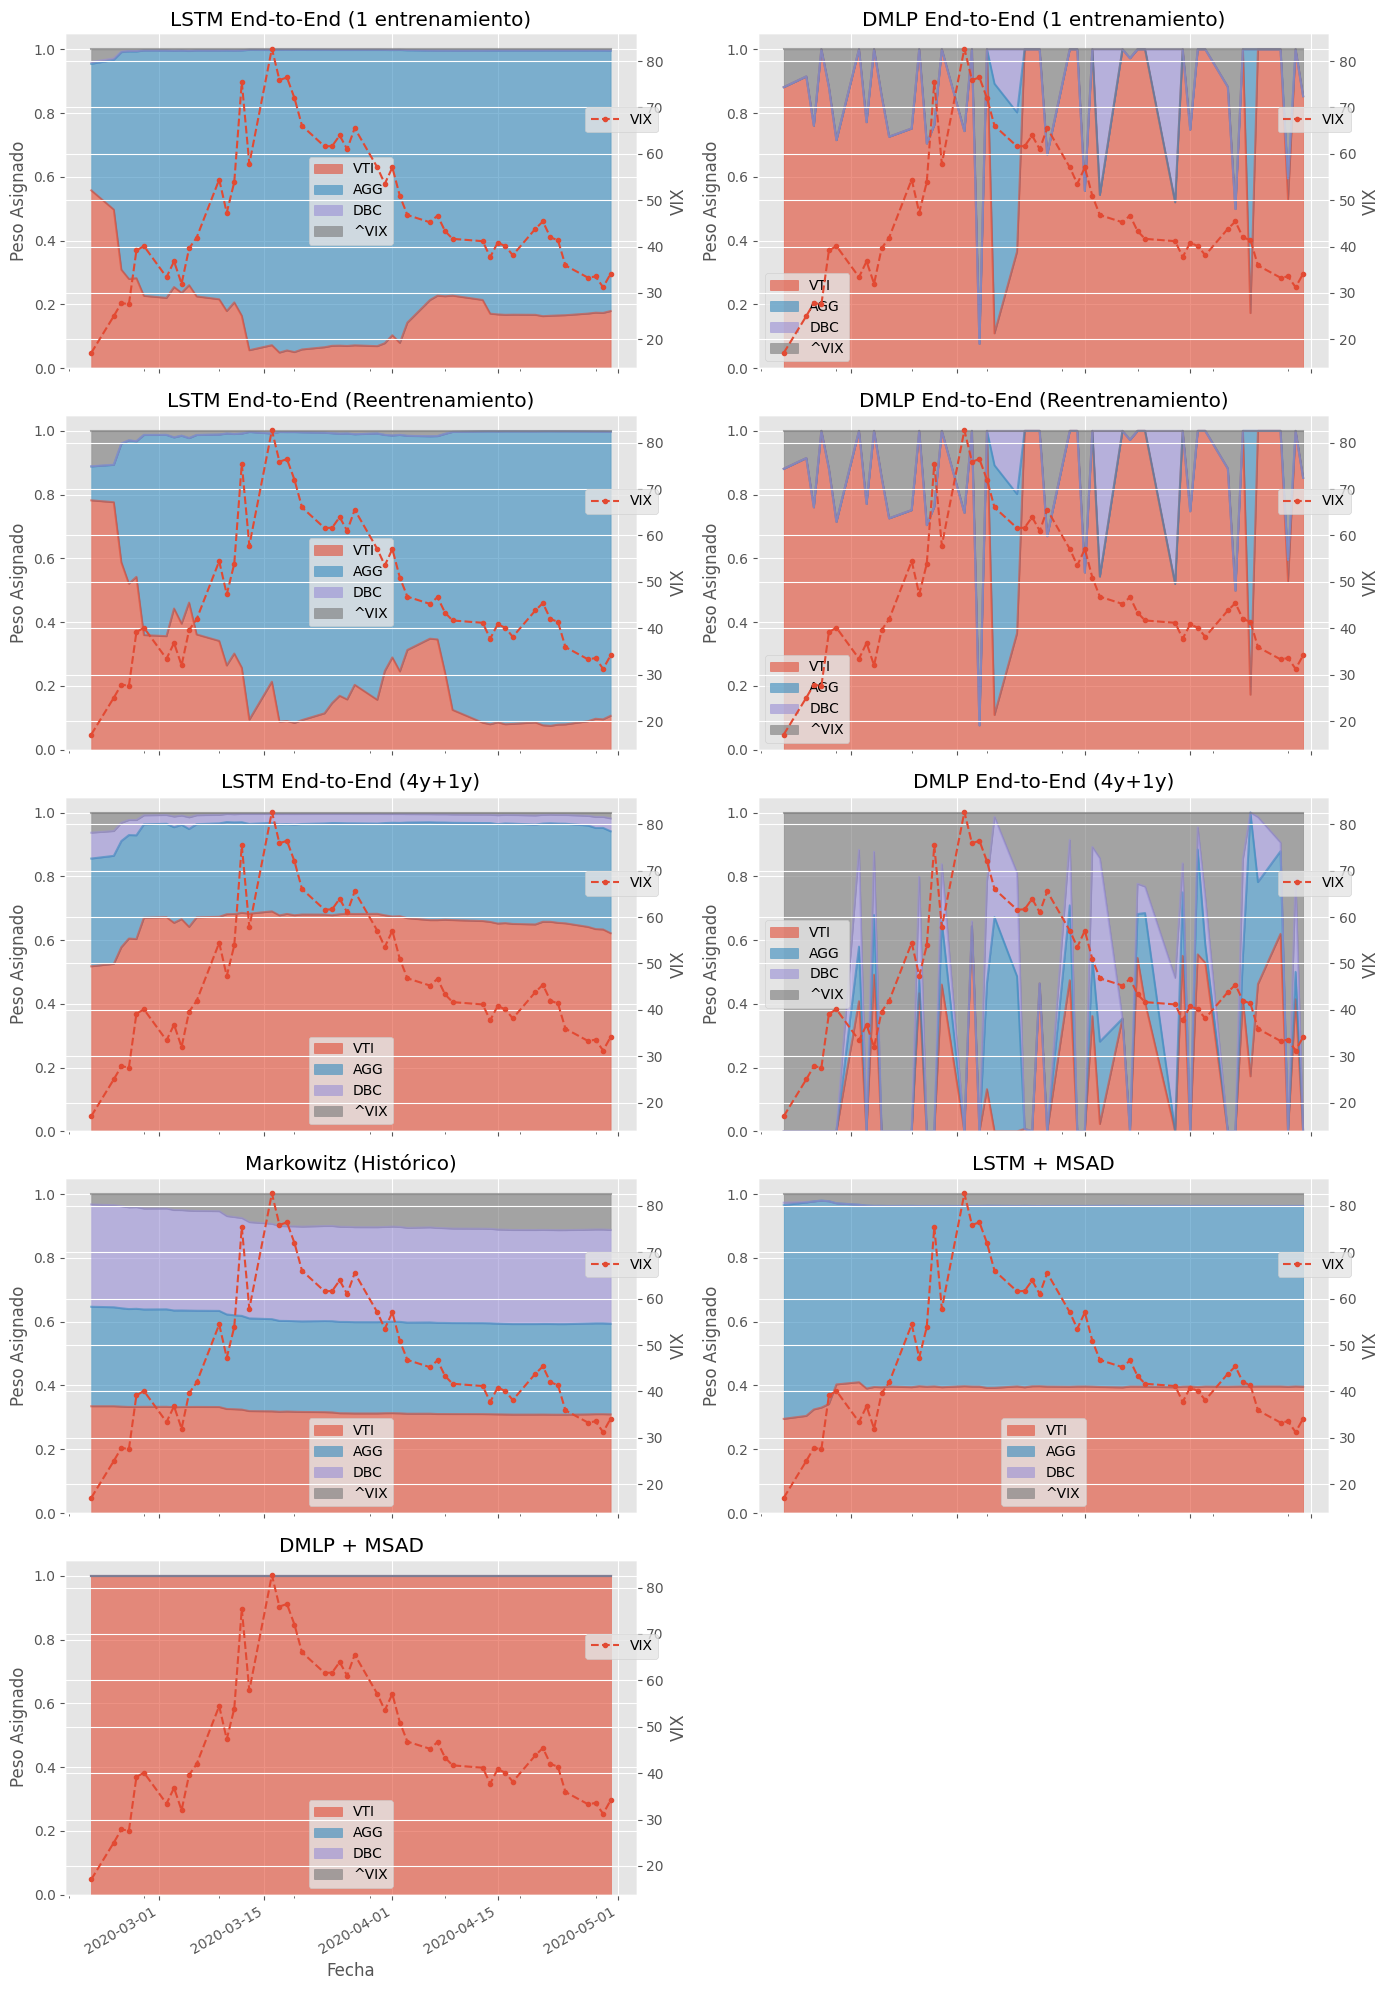

Gráficas de asignaciones diarias con línea de VIX generadas exitosamente.
Evaluación detallada para Modelos LSTM+MSAD y DMLP+MSAD:


,MAE (mean),MAE (std),MSE (mean),MSE (std),HR (mean),HR (std),HR+ (mean),HR+ (std),HR- (mean),HR- (std)
LSTM+MSAD,0.048294,0.047510,0.008586,0.012987,0.520408,0.071429,0.6875,0.409840,0.310345,0.410185
DMLP+MSAD,0.040775,0.038282,0.005749,0.008511,0.510204,0.082898,0.7500,0.433013,0.250000,0.433013


In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1) DataFrames de pesos por cada estrategia
df_weights_single        = pd.DataFrame(weights_pred_single,       index=pred_dates_single,    columns=tickers)
df_weights_dmlp_raw      = pd.DataFrame(weights_pred_dmlp_raw,     index=pred_dates_dmlp_raw,  columns=tickers)
df_weights_retrain       = pd.DataFrame(weights_pred_retrain,      index=pred_dates_retrain,   columns=tickers)
df_weights_dmlp_retrain  = pd.DataFrame(weights_dmlp_retrain,      index=dates_dmlp_retrain,   columns=tickers)
df_weights_4y1y          = pd.DataFrame(weights_4y,                index=pred_dates_4y,        columns=tickers)
df_weights_dmlp_4y1y     = pd.DataFrame(weights_dmlp_4y,           index=dates_dmlp_4y,        columns=tickers)
df_weights_mk            = pd.DataFrame(weights_markowitz,         index=global_pred_dates,    columns=tickers)
df_weights_lstm_msad     = pd.DataFrame(optimized_weights_lstm_msad, index=pred_dates_msad,     columns=tickers)
df_weights_dmlp_msad     = pd.DataFrame(optimized_weights_dmlp_msad, index=pred_dates_msad,     columns=tickers)

model_weights = {
    "LSTM End-to-End (1 entrenamiento)"    : df_weights_single,
    "DMLP End-to-End (1 entrenamiento)"    : df_weights_dmlp_raw,
    "LSTM End-to-End (Reentrenamiento)"    : df_weights_retrain,
    "DMLP End-to-End (Reentrenamiento)"    : df_weights_dmlp_retrain,
    "LSTM End-to-End (4y+1y)"             : df_weights_4y1y,
    "DMLP End-to-End (4y+1y)"             : df_weights_dmlp_4y1y,
    "Markowitz (Histórico)"               : df_weights_mk,
    "LSTM + MSAD"                          : df_weights_lstm_msad,
    "DMLP + MSAD"                          : df_weights_dmlp_msad
}

# 2) Normalizar pesos (por si acaso hay ligeros desbalances numéricos)
for name, df_w in model_weights.items():
    df_w[df_w < 0] = 0.0
    df_w /= df_w.sum(axis=1).values.reshape(-1, 1)
    model_weights[name] = df_w

# 3) Área apilada con línea de VIX
n_models = len(model_weights)
ncols = 2
nrows = math.ceil(n_models / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows), sharex=True)
axes = axes.flatten()

for i, (model_name, df_w) in enumerate(model_weights.items()):
    df_w = df_w.sort_index()
    df_w.plot.area(ax=axes[i], stacked=True, alpha=0.6)
    axes[i].set_title(model_name)
    axes[i].set_xlabel("Fecha")
    axes[i].set_ylabel("Peso Asignado")

    ax2 = axes[i].twinx()
    vix_series = combined_data.loc[df_w.index, "^VIX_Adj Close"]
    ax2.plot(vix_series.index, vix_series.values, linestyle="--", marker="o", markersize=3, label="VIX")
    ax2.set_ylabel("VIX")
    ax2.legend(loc="upper right", bbox_to_anchor=(1.05, 0.8))

# Quitar ejes sobrantes
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
print("Gráficas de asignaciones diarias con línea de VIX generadas exitosamente.")

# 4) Evaluación detallada para MSAD

def get_y_true_for_msad(pred_dates):
    log_return_cols = [f"{t}_Log Return" for t in tickers]
    return np.vstack([combined_data.loc[d, log_return_cols].values for d in pred_dates])

def compute_metrics_per_asset(y_true, y_pred):
    n_assets = y_true.shape[1]
    mae_vals = []
    mse_vals = []
    hr_vals = []
    hr_plus_vals = []
    hr_minus_vals = []

    for j in range(n_assets):
        mae_j = mean_absolute_error(y_true[:, j], y_pred[:, j])
        mse_j = mean_squared_error(y_true[:, j], y_pred[:, j])
        hr_j = np.mean(np.sign(y_pred[:, j]) == np.sign(y_true[:, j]))
        pos_idx = np.where(y_true[:, j] > 0)[0]
        hr_plus_j = np.mean(np.sign(y_pred[pos_idx, j]) > 0) if len(pos_idx) > 0 else np.nan
        neg_idx = np.where(y_true[:, j] < 0)[0]
        hr_minus_j = np.mean(np.sign(y_pred[neg_idx, j]) < 0) if len(neg_idx) > 0 else np.nan

        mae_vals.append(mae_j)
        mse_vals.append(mse_j)
        hr_vals.append(hr_j)
        hr_plus_vals.append(hr_plus_j)
        hr_minus_vals.append(hr_minus_j)

    return {
        "MAE (mean)":  np.nanmean(mae_vals),
        "MAE (std)":   np.nanstd(mae_vals),
        "MSE (mean)":  np.nanmean(mse_vals),
        "MSE (std)":   np.nanstd(mse_vals),
        "HR (mean)":   np.nanmean(hr_vals),
        "HR (std)":    np.nanstd(hr_vals),
        "HR+ (mean)":  np.nanmean(hr_plus_vals),
        "HR+ (std)":   np.nanstd(hr_plus_vals),
        "HR- (mean)":  np.nanmean(hr_minus_vals),
        "HR- (std)":   np.nanstd(hr_minus_vals)
    }

y_true_msad = get_y_true_for_msad(pred_dates_msad)
metrics_lstm_msad = compute_metrics_per_asset(y_true_msad, predicted_lstm_msad)
metrics_dmlp_msad = compute_metrics_per_asset(y_true_msad, predicted_dmlp_msad)

df_metrics_extended = pd.DataFrame(
    [metrics_lstm_msad, metrics_dmlp_msad],
    index=["LSTM+MSAD", "DMLP+MSAD"]
)

print("Evaluación detallada para Modelos LSTM+MSAD y DMLP+MSAD:")
display(df_metrics_extended)
